<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/spline_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


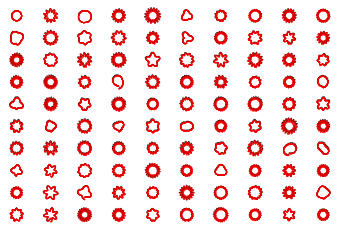

In [40]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,2*numpoints)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:numpoints] = x[l,:]#modified for lstm discriminator
        points[l,-numpoints:] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            temp = sample.unsqueeze(0).cuda()
            temp = torch.cat([temp,temp]).cuda()
            pred = model(temp)
            pred = pred[0]
            print('pred', pred.shape)
            predres = (int)(pred.shape[0]/2)
            #print(pred.shape,predres, predres/2)
            X = pred[:predres]
            Y = pred[-predres:]
            #print('X',X.shape)
            #print(Y.shape)

            #print (X.shape,Y.shape)
            s = [.001 for x in range(predres)]
            print('s',len(s))
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            print('c',len(c))
            assert len(c) == predres
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:numpoints]
        Y = labels[-numpoints:]
        s = [.001 for x in range(numpoints)]
        print(len(s))
        c = ['red' for x in range(numpoints)]
        print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        #canvas = torch.from_numpy(canvas)
        #canvas = canvas.repeat(3, 1, 1).float()
        #print('canvashape',canvas.shape)
        #canvas = torch.cat([canvas,columns.unsqueeze(0),rows.unsqueeze(0)])
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]

        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)

In [41]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url



class MLPGEN(nn.Module):

    def __init__(self):
        super(MLPGEN, self).__init__()
        self.hidden_dim = 32*32
        self.featurevector = None
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 2000),
            nn.Sigmoid()
        
        )
    

    def forward(self, x):
        #print(self.featurevector.shape)
        print(x.shape)
        first = x.shape[0]
        x = torch.flatten(x[:,0,:,:],start_dim=1)
        if x.shape != (first,self.hidden_dim):
            print('bad shape', x.shape)

        assert x.shape == (first,self.hidden_dim)
        return 32.0*self.mlp(x)

In [42]:
model = MLPGEN().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.5, 0.999), weight_decay=0.1)


In [43]:
def my_loss(output, target):
    loss = torch.mean(torch.abs(output - target))
    return loss


In [44]:
dataset_train = DonutDataset(4000)
dataset_val = DonutDataset(100)

torch.Size([4000, 1]) torch.Size([4000, 1]) torch.Size([4000, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [45]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

loader_train = data.DataLoader(
    dataset_train, batch_size=64,
    sampler=RandomSampler(data_source = dataset_train),
    num_workers=4)
loader_train = loader_train
model.train()
for i in range(10):
  for x,y in loader_train:
    x = x.cuda()
    y = y.cuda()
    generated_sequence = model(x)
    loss = my_loss(generated_sequence, y)
    loss.backward()
    print(loss)
    optimizer.step()


torch.Size([64, 1, 32, 32])
tensor(5.9209, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9904, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9973, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9927, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9035, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9931, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(6.0093, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.7911, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.8604, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9114, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9602, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([64, 1, 32, 32])
tensor(5.9822, device='cuda:0', grad_

sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Siz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:171: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Size([2, 1, 32, 32])
pred torch.Size([2000])
s 1000
c 1000
sample torch.Size([1, 32, 32])
torch.Siz

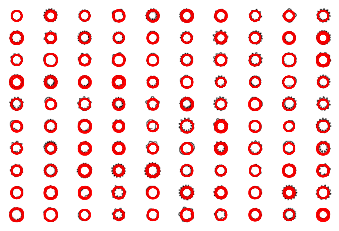

In [46]:
DonutDataset.displayCanvas('training-set.png', dataset_train, model)
DonutDataset.displayCanvas('validation-set.png', dataset_val, model)